# <center><span style='background:yellow'> Détectez les Bad Buzz grâce au Deep Learning</span></center>
# <center><span style='background:yellow'>Modèle de Deep Learning avec une couche embedding</span></center> 
===================================================================================================================

## Sommaire <a class="anchor" id="sommaire"></a>

* [Import des librairies, chargement des données](#00)
* [1. Nettoyage avec lemmatisation et vectorisation avec Word2Vec](#10)  
* [2. Nettoyage avec lemmatisation et vectorisation avec Glove](#20)  
* [3. Nettoyage avec Stemming et vectorisation avec Word2Vec](#30)  
* [4. Nettoyage avec Stemming et vectorisation avec Glove](#40)  

## Import des librairies, chargement des données<a class="anchor" id="00"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 96.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import gensim
from gensim.models import KeyedVectors
import keras
import gensim.downloader
import tensorflow
from tensorflow.keras import models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import models, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, GlobalAveragePooling1D

print('Tensorflow version :', tensorflow.__version__)
print('Keras version :', keras.__version__)
print('gensim version :', gensim.__version__)

Tensorflow version : 2.9.2
Keras version : 2.9.0
gensim version : 4.2.0


In [ ]:
# Chargement des données
path = '/content/drive/MyDrive/p7/'

In [ ]:
train = pd.read_csv(path + 'data/train.csv', index_col=0, encoding='utf-8')
validation = pd.read_csv(path + 'data/validation.csv', index_col=0, encoding='utf-8')
test = pd.read_csv(path + 'data/test.csv', index_col=0, encoding='utf-8')

train.dropna(inplace=True)
validation.dropna(inplace=True)
test.dropna(inplace=True)

In [ ]:
train.head()

,tweet,label,tweet_clean_lemm,tweet_clean_stem
1273151,#Goodsex When he makes you squirt all over him,1,goodsex make squirt,goodsex make squirt
445145,Looking for a &quot;Sexy Sailors&quot; outfit ...,0,look quot;sexy sailors&quot outfit laura hen n...,look quot;sexi sailors&quot outfit laura hen n...
499993,i dont know why twitter just now sent that thr...,0,not know twitter send word headache,nt know twitter sent word headach
122529,A particularly brutal rejection has put me off...,0,particularly brutal rejection writing never co...,particular brutal reject write never consid eg...
1322335,@bets_carabuena dear! sa friday pa dito thurs...,1,dear sa friday pa dito thursday ang game,dear sa friday pa dito thursday ang game


In [ ]:
train_lem = train.tweet_clean_lemm
train_stem = train.tweet_clean_stem

val_lem = validation.tweet_clean_lemm
val_stem = validation.tweet_clean_stem

test_lem = test.tweet_clean_lemm
test_stem = test.tweet_clean_stem

In [ ]:
ytrain, yval = train.label, validation.label

In [ ]:
epochs = 100
batch_size = 500

<a href="##sommaire" rev="footnote">&#8617;</a>

## Nettoyage avec lemmatisation et vectorisation avec Word2Vec<a class="anchor" id="10"></a>

In [ ]:
# Création et entraînement du modèle Word2Vec
def w2v_vectors(serie, vector_size=200, min_count=1, window=4, epochs=100, random_state=0):
    sentences = serie.to_list()
    sentences =  [gensim.utils.simple_preprocess(text) for text in sentences]
    
    print("Build & train Word2Vec model ...")
    model  = gensim.models.Word2Vec(min_count = min_count,
                                       window = window,
                                       vector_size = vector_size,
                                       seed = random_state,
                                       workers = 4)

    model.build_vocab(sentences)
    model.train(sentences, 
                total_examples = model.corpus_count, 
                epochs = epochs)
    model_vectors  =  model.wv
    words  =  model_vectors.key_to_index
    print("Vocabulary size:", len(words))
    print("Word2Vec trained")
    return model_vectors

In [ ]:
w2v_vectors_lemm = w2v_vectors(train_lem)
w2v_vectors_stem = w2v_vectors(train_stem)

Build & train Word2Vec model ...
Vocabulary size: 141428
Word2Vec trained
Build & train Word2Vec model ...
Vocabulary size: 126340
Word2Vec trained


In [ ]:
w2v_vectors_lemm.save(path + "embedding/lemm_word2vec.wordvectors")
w2v_vectors_stem.save(path + "embedding/stem_word2vec.wordvectors")

In [ ]:
# w2v_vectors_lemm = KeyedVectors.load(path + "embedding/lemm_word2vec.wordvectors")
# w2v_vectors_stem = KeyedVectors.load(path + "embedding/stem_word2vec.wordvectors")

**Test le tokenizer de Keras**

In [ ]:
seed = 0
tk = Tokenizer()
tk.fit_on_texts(train_lem.to_list())

In [ ]:
tk.document_count

625617

In [ ]:
len(tk.word_counts)

154397

In [ ]:
list(tk.word_counts.items())[:10]

[('goodsex', 57),
 ('make', 7137),
 ('squirt', 14),
 ('look', 15632),
 ('quot', 28563),
 ('sexy', 727),
 ('sailors', 2),
 ('outfit', 209),
 ('laura', 175),
 ('hen', 39)]

In [ ]:
list(tk.word_index.items())[:10]

[('not', 1),
 ('go', 2),
 ('good', 3),
 ('day', 4),
 ('work', 5),
 ('get', 6),
 ('like', 7),
 ('love', 8),
 ('quot', 9),
 ('today', 10)]

In [ ]:
SeqText = tk.texts_to_sequences(train_lem.to_list())

In [ ]:
SeqText[:4]

[[5472, 75, 13056],
 [26, 9, 761, 40321, 9, 2144, 2446, 7010, 21, 899, 410, 1, 7],
 [1, 14, 31, 162, 274, 264],
 [4426, 4796, 8408, 1418, 76, 937, 3539, 7011, 533]]

In [ ]:
train.tweet_clean_lemm.iloc[:4,]

1273151                                  goodsex make squirt
445145     look quot;sexy sailors&quot outfit laura hen n...
499993                   not know twitter send word headache
122529     particularly brutal rejection writing never co...
Name: tweet_clean_lemm, dtype: object

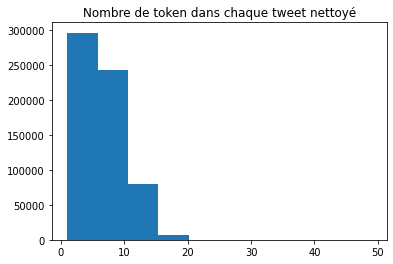

In [ ]:
plt.hist([len(doc) for doc in SeqText])
plt.title('Nombre de token dans chaque tweet nettoyé')
plt.show()

In [ ]:
max_len = max([len(doc) for doc in SeqText])

In [ ]:
np.argmax([len(doc) for doc in SeqText])

112406

In [ ]:
# Création de la matrice d'embedding
def build_embedding_matrix(serie, model_vectors, size = 200):
    list_docs = serie.to_list()
    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list_docs)
    print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, size))
    i=0
    j=0
    miss = []
    for word, idx in word_index.items():
        i +=1
        if word in model_vectors.key_to_index:
            j +=1
            embedding_vector = model_vectors[word]
            
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
                
            else :
                miss.append(word)
            
    word_rate = np.round(j/i,4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix shape: " , embedding_matrix.shape)
    
    return {'Embedding_matrix' : embedding_matrix, 'Words_not_found' : miss}

In [ ]:
size = 200
embedding_matrix_lem_w2v = build_embedding_matrix(train_lem, 
                                                  model_vectors = w2v_vectors_lemm, 
                                                  size = size)['Embedding_matrix']

Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  0.8915
Embedding matrix shape:  (154398, 200)


In [ ]:
  # Définition de la fonction de Préparation des sentences (tokenization)
  def prepare_data(serie, maxlen = 205, tokenizer=tk, pprint = None):
      if pprint:
          print(pprint)
      list_docs = serie.to_list()
      tokenizer.texts_to_sequences(list_docs)
      input_data = pad_sequences(tokenizer.texts_to_sequences(list_docs),
                                  maxlen = maxlen,
                                  padding = 'post')
      print('Len vocab :', len(tk.word_counts))
      print('Len tweets :', input_data.shape[0])
      print('Done! \n')
      return input_data

In [ ]:
xtrain_lem = prepare_data(train_lem, pprint='Preparing the train set : ')

xval_lem = prepare_data(val_lem, pprint='Preparing the validation set : ')

xtest_lem = prepare_data(test_lem, pprint='Preparing the test set : ')

Preparing the train set : 
Len vocab : 154397
Len tweets : 625617
Done! 

Preparing the validation set : 
Len vocab : 154397
Len tweets : 268092
Done! 

Preparing the test set : 
Len vocab : 154397
Len tweets : 99333
Done! 



In [ ]:
# Save test input
np.save(path + 'test_input/xtest_lem.npy', xtest_lem)

In [ ]:
xtrain_lem.shape, xval_lem.shape, ytrain.shape, yval.shape

((625617, 205), (268092, 205), (625617,), (268092,))

In [ ]:
embedding_matrix_lem_w2v.shape

(154398, 200)

### Baseline

In [ ]:
def model_embedding(embedding_matrix, 
                    len_vocab = 154_397 + 1,
                    output_dim = 200,
                    max_len = 200,
                    len_padding = 5,
                    seed=0):

  tensorflow.random.set_seed(seed)

  model = Sequential()

  model.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                             trainable = False))

  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))
  model.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])
  return model

In [ ]:
embedding_matrix = embedding_matrix_lem_w2v
model_lemm_w2v = model_embedding(embedding_matrix = embedding_matrix,
                                 seed = seed)

model_lemm_w2v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 205, 200)          30879600  
                                                                 
 flatten (Flatten)           (None, 41000)             0         
                                                                 
 dense (Dense)               (None, 1)                 41001     
                                                                 
Total params: 30,920,601
Trainable params: 41,001
Non-trainable params: 30,879,600
_________________________________________________________________


In [ ]:
history_lemm_w2v = model_lemm_w2v.fit(xtrain_lem, 
                             ytrain,
                             validation_data = (xval_lem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 0)

In [ ]:
def plot_history(history, list_key) :
    
    # summarize history for accuracy
    plt.plot(history.history[list_key[0]])
    plt.plot(history.history[list_key[2]])
    plt.title(f'model {list_key[0]}')
    plt.ylabel(list_key[0])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history[list_key[1]])
    plt.plot(history.history[list_key[3]])
    plt.title(f'model {list_key[1]}')
    plt.ylabel(list_key[1])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Learning Curve

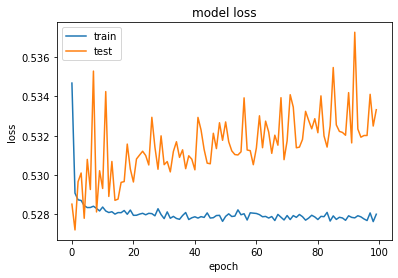

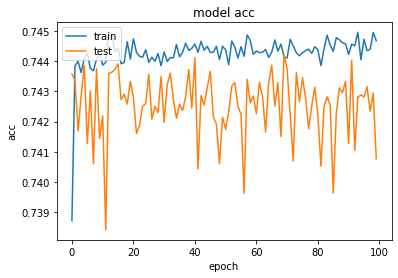

In [ ]:
history = history_lemm_w2v
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [ ]:
evaluate = model_lemm_w2v.evaluate(xval_lem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.53 : 
Accuracy score: 0.74


### Amélioration du modèle

In [ ]:
embedding_matrix = embedding_matrix_lem_w2v
len_vocab = 154397 + 1
output_dim = 200
max_len = 200
len_padding = 5

tensorflow.random.set_seed(seed)

model_lemm_w2v_optimised = Sequential()

model_lemm_w2v_optimised.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                             trainable = False))
model_lemm_w2v_optimised.add(GlobalAveragePooling1D())
model_lemm_w2v_optimised.add(Flatten())
model_lemm_w2v_optimised.add(Dense(20, activation='relu'))
model_lemm_w2v_optimised.add(Dropout(0.4))
model_lemm_w2v_optimised.add(Dense(1, activation="sigmoid"))
model_lemm_w2v_optimised.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])

In [ ]:
model_lemm_w2v_optimised.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 205, 200)          30879600  
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                4020      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                      

In [ ]:
from time import time
t0 = time()
history_lemm_w2v_optimised = model_lemm_w2v_optimised.fit(xtrain_lem, 
                             ytrain,
                             validation_data = (xval_lem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)
t_lemm_w2v_optimised = time() - t0

Epoch 1/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5705 - acc: 0.7144 - val_loss: 0.5247 - val_acc: 0.7417
Epoch 2/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5295 - acc: 0.7413 - val_loss: 0.5150 - val_acc: 0.7466
Epoch 3/100
1252/1252 [==============================] - 7s 6ms/step - loss: 0.5237 - acc: 0.7439 - val_loss: 0.5123 - val_acc: 0.7476
Epoch 4/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5215 - acc: 0.7454 - val_loss: 0.5095 - val_acc: 0.7489
Epoch 5/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5197 - acc: 0.7463 - val_loss: 0.5077 - val_acc: 0.7496
Epoch 6/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5183 - acc: 0.7472 - val_loss: 0.5066 - val_acc: 0.7505
Epoch 7/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5174 - acc: 0.7480 - val_loss: 0.5045 - val_acc: 0.7515
Epoch 8/100
1252/1252 [==============================] 

#### Learning Curve

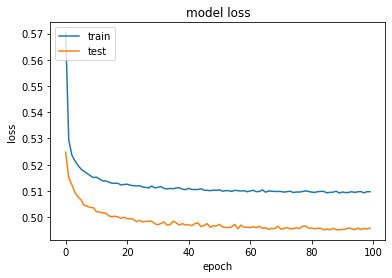

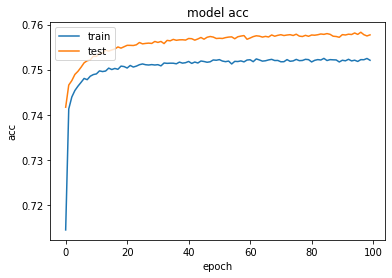

In [ ]:
history = history_lemm_w2v_optimised
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [ ]:
evaluate = model_lemm_w2v_optimised.evaluate(xval_lem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.50 : 
Accuracy score: 0.76


#### Sauvegarde du modèle

In [ ]:
# saving model

model_lemm_w2v_optimised.save(path + 'models/model_lemm_w2v')

<a href="##sommaire" rev="footnote">&#8617;</a>

## Nettoyage avec lemmatisation et vectorisation avec Glove<a class="anchor" id="20"></a>

In [ ]:
# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load('glove-twitter-200')
glove_vectors.save(path + "embedding/glove.wordvectors")

# glove_vectors = KeyedVectors.load(path + "embedding/glove.wordvectors")

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
embedding_matrix_lemm_glove = build_embedding_matrix(train_lem, glove_vectors)['Embedding_matrix']

Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  0.5262
Embedding matrix shape:  (154398, 200)


### Baseline

In [ ]:
embedding_matrix = embedding_matrix_lemm_glove
model_lemm_glove = model_embedding(embedding_matrix = embedding_matrix, 
                                   seed = 0)
model_lemm_glove.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 205, 200)          30879600  
                                                                 
 flatten_2 (Flatten)         (None, 41000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 41001     
                                                                 
Total params: 30,920,601
Trainable params: 41,001
Non-trainable params: 30,879,600
_________________________________________________________________


In [ ]:
history_lemm_glove = model_lemm_glove.fit(xtrain_lem, 
                             ytrain,
                             validation_data = (xval_lem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

Epoch 1/100
1252/1252 [==============================] - 8s 6ms/step - loss: 0.5393 - acc: 0.7335 - val_loss: 0.5282 - val_acc: 0.7403
Epoch 2/100
1252/1252 [==============================] - 7s 5ms/step - loss: 0.5261 - acc: 0.7429 - val_loss: 0.5263 - val_acc: 0.7427
Epoch 3/100
1252/1252 [==============================] - 7s 6ms/step - loss: 0.5252 - acc: 0.7437 - val_loss: 0.5269 - val_acc: 0.7431
Epoch 4/100
1252/1252 [==============================] - 6s 4ms/step - loss: 0.5250 - acc: 0.7438 - val_loss: 0.5269 - val_acc: 0.7433
Epoch 5/100
1252/1252 [==============================] - 6s 4ms/step - loss: 0.5247 - acc: 0.7438 - val_loss: 0.5273 - val_acc: 0.7417
Epoch 6/100
1252/1252 [==============================] - 6s 4ms/step - loss: 0.5246 - acc: 0.7440 - val_loss: 0.5272 - val_acc: 0.7422
Epoch 7/100
1252/1252 [==============================] - 6s 4ms/step - loss: 0.5246 - acc: 0.7439 - val_loss: 0.5269 - val_acc: 0.7420
Epoch 8/100
1252/1252 [==============================] 

#### Learning Curve

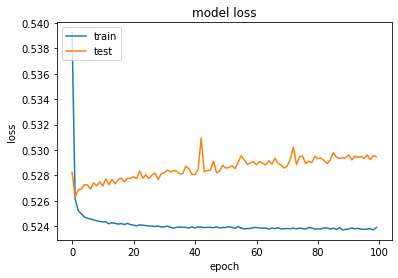

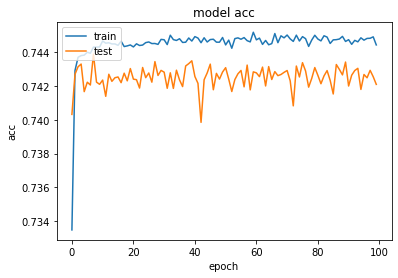

In [ ]:
history = history_lemm_glove
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [ ]:
evaluate = model_lemm_glove.evaluate(xval_lem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.53 : 
Accuracy score: 0.74


### Amélioration du modèle

In [ ]:
len_vocab = 154_397 + 1
output_dim = 200
max_len = 200
len_padding = 5
embedding_matrix = embedding_matrix_lemm_glove

tensorflow.random.set_seed(seed)

model_lemm_glove_optimised = Sequential()

model_lemm_glove_optimised.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                             trainable = False))
model_lemm_glove_optimised.add(GlobalAveragePooling1D())
model_lemm_glove_optimised.add(Flatten())
model_lemm_glove_optimised.add(Dense(40, activation='relu'))
model_lemm_glove_optimised.add(Dropout(0.50))
model_lemm_glove_optimised.add(Dense(20, activation='relu'))
model_lemm_glove_optimised.add(Dropout(0.5))
model_lemm_glove_optimised.add(Dense(1, activation="sigmoid"))
model_lemm_glove_optimised.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])

In [ ]:
model_lemm_glove_optimised.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 205, 200)          30879600  
                                                                 
 global_average_pooling1d_1   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 40)                8040      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 20)                820       
                                                      

In [ ]:
t0 = time()
history_lemm_glove_optimised = model_lemm_glove_optimised.fit(xtrain_lem, 
                             ytrain,
                             validation_data = (xval_lem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

t_lemm_glove_optimised = time() - t0

Epoch 1/100
1252/1252 [==============================] - 7s 5ms/step - loss: 0.5675 - acc: 0.7128 - val_loss: 0.5198 - val_acc: 0.7419
Epoch 2/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5349 - acc: 0.7390 - val_loss: 0.5123 - val_acc: 0.7465
Epoch 3/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5313 - acc: 0.7419 - val_loss: 0.5099 - val_acc: 0.7483
Epoch 4/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5287 - acc: 0.7441 - val_loss: 0.5078 - val_acc: 0.7492
Epoch 5/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5274 - acc: 0.7448 - val_loss: 0.5070 - val_acc: 0.7498
Epoch 6/100
1252/1252 [==============================] - 7s 5ms/step - loss: 0.5255 - acc: 0.7457 - val_loss: 0.5047 - val_acc: 0.7520
Epoch 7/100
1252/1252 [==============================] - 7s 5ms/step - loss: 0.5246 - acc: 0.7471 - val_loss: 0.5034 - val_acc: 0.7516
Epoch 8/100
1252/1252 [==============================] 

#### Learning Curve

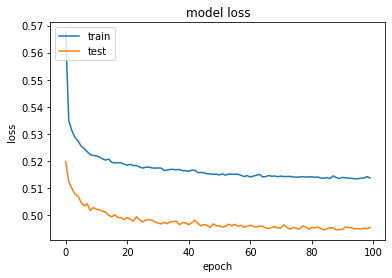

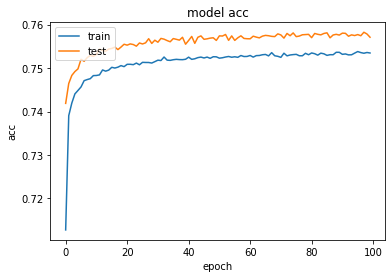

In [ ]:
history = history_lemm_glove_optimised
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [ ]:
evaluate = model_lemm_glove_optimised.evaluate(xval_lem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.50 : 
Accuracy score: 0.76


#### Sauvegarde du modèle

In [ ]:
# saving model

model_lemm_glove_optimised.save(path + 'models/model_lemm_glove')

<a href="##sommaire" rev="footnote">&#8617;</a>

## Nettoyage avec stemming et vectorisation avec Word2Vec <a class="anchor" id="30"></a>

In [ ]:
tk_stem = Tokenizer()
tk_stem.fit_on_texts(train_stem)

In [ ]:
len(tk_stem.index_word)

138807

In [ ]:
size = 200
embedding_matrix_stem_w2v = build_embedding_matrix(train_stem, 
                                                  model_vectors = w2v_vectors_stem, 
                                                  size = size)['Embedding_matrix']

Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  0.8831
Embedding matrix shape:  (138808, 200)


In [ ]:
xtrain_stem = prepare_data(train_stem, tokenizer=tk_stem, 
                           pprint='Préparing the train set : ')

xval_stem = prepare_data(val_stem, tokenizer=tk_stem, 
                         pprint='Préparing the validation set : ')

xtest_stem = prepare_data(test_stem, tokenizer=tk_stem, 
                         pprint='Préparing the validation set : ')

Préparing the train set : 
Len vocab : 154397
Len tweets : 625617
Done! 

Préparing the validation set : 
Len vocab : 154397
Len tweets : 268092
Done! 

Préparing the validation set : 
Len vocab : 154397
Len tweets : 99333
Done! 



In [ ]:
# Save test input
np.save(path + 'test_input/xtest_stem.npy', xtest_stem)

### Baseline

In [ ]:
embedding_matrix = embedding_matrix_stem_w2v
model_stem_w2v = model_embedding(embedding_matrix=embedding_matrix, 
                                 len_vocab = 138807+1)

model_stem_w2v.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 205, 200)          27761600  
                                                                 
 flatten_4 (Flatten)         (None, 41000)             0         
                                                                 
 dense_7 (Dense)             (None, 1)                 41001     
                                                                 
Total params: 27,802,601
Trainable params: 41,001
Non-trainable params: 27,761,600
_________________________________________________________________


In [ ]:
history_stem_w2v = model_stem_w2v.fit(xtrain_stem, 
                             ytrain,
                             validation_data = (xval_stem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

Epoch 1/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5333 - acc: 0.7402 - val_loss: 0.5277 - val_acc: 0.7438
Epoch 2/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5275 - acc: 0.7450 - val_loss: 0.5258 - val_acc: 0.7443
Epoch 3/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5271 - acc: 0.7458 - val_loss: 0.5280 - val_acc: 0.7435
Epoch 4/100
1252/1252 [==============================] - 6s 4ms/step - loss: 0.5271 - acc: 0.7450 - val_loss: 0.5272 - val_acc: 0.7447
Epoch 5/100
1252/1252 [==============================] - 6s 4ms/step - loss: 0.5270 - acc: 0.7455 - val_loss: 0.5264 - val_acc: 0.7446
Epoch 6/100
1252/1252 [==============================] - 6s 4ms/step - loss: 0.5268 - acc: 0.7453 - val_loss: 0.5281 - val_acc: 0.7436
Epoch 7/100
1252/1252 [==============================] - 7s 6ms/step - loss: 0.5267 - acc: 0.7456 - val_loss: 0.5265 - val_acc: 0.7451
Epoch 8/100
1252/1252 [==============================] 

#### Learning Curve

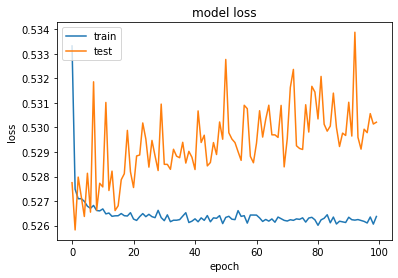

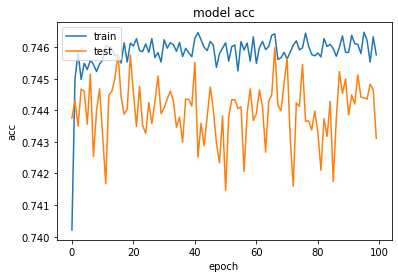

In [ ]:
history = history_stem_w2v
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [ ]:
evaluate = model_stem_w2v.evaluate(xval_stem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f '%(evaluate[0], evaluate[1]))

Loss score 0.53 : 
Accuracy score: 0.74 


### Amélioration du modèle

In [ ]:
len_vocab = 138807+1
output_dim = 200
max_len = 200
len_padding = 5



tensorflow.random.set_seed(seed)

model_stem_w2v_optimised = Sequential()

model_stem_w2v_optimised.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                             trainable = False))

model_stem_w2v_optimised.add(GlobalAveragePooling1D())
model_stem_w2v_optimised.add(Flatten())
model_stem_w2v_optimised.add(Dense(10, activation='relu'))
model_stem_w2v_optimised.add(Dropout(0.30))
model_stem_w2v_optimised.add(Dense(10, activation='relu'))
model_stem_w2v_optimised.add(Dropout(0.30))
model_stem_w2v_optimised.add(Dense(1, activation="sigmoid"))
model_stem_w2v_optimised.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])

In [ ]:
model_stem_w2v_optimised.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 205, 200)          27761600  
                                                                 
 global_average_pooling1d_2   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                2010      
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 10)                110       
                                                      

In [ ]:
from time import time
t0 = time()
history_stem_w2v_optimised = model_stem_w2v_optimised.fit(xtrain_stem, 
                             ytrain,
                             validation_data = (xval_stem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)
t_stem_w2v_optimised = time() - t0

Epoch 1/100
1252/1252 [==============================] - 7s 5ms/step - loss: 0.5713 - acc: 0.7143 - val_loss: 0.5193 - val_acc: 0.7464
Epoch 2/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5354 - acc: 0.7420 - val_loss: 0.5111 - val_acc: 0.7508
Epoch 3/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5321 - acc: 0.7441 - val_loss: 0.5097 - val_acc: 0.7511
Epoch 4/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5298 - acc: 0.7453 - val_loss: 0.5082 - val_acc: 0.7512
Epoch 5/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5278 - acc: 0.7461 - val_loss: 0.5052 - val_acc: 0.7534
Epoch 6/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5272 - acc: 0.7460 - val_loss: 0.5053 - val_acc: 0.7530
Epoch 7/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5263 - acc: 0.7461 - val_loss: 0.5030 - val_acc: 0.7533
Epoch 8/100
1252/1252 [==============================] 

#### Learning Curve

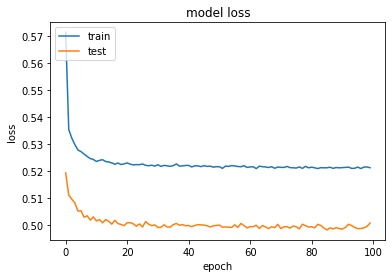

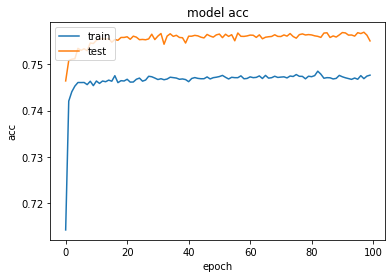

In [ ]:
history = history_stem_w2v_optimised
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [ ]:
evaluate = model_stem_w2v_optimised.evaluate(xval_stem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.50 : 
Accuracy score: 0.76


#### Sauvegarde du modèle

In [ ]:
# saving model 

model_stem_w2v_optimised.save(path + 'models/model_stem_w2v')

<a href="##sommaire" rev="footnote">&#8617;</a>

## Nettoyage avec stemming et vectorisation avec Glove<a class="anchor" id="4"> </a>

In [ ]:
embedding_matrix_stem_glove = build_embedding_matrix(train_stem, glove_vectors)['Embedding_matrix']

Fit Tokenizer ...
Create Embedding matrix ...
Word embedding rate :  0.448
Embedding matrix shape:  (138808, 200)


### Baseline

In [ ]:
embedding_matrix = embedding_matrix_stem_glove
model_stem_glove = model_embedding(embedding_matrix=embedding_matrix, len_vocab=138808)
model_stem_glove.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 205, 200)          27761600  
                                                                 
 flatten_6 (Flatten)         (None, 41000)             0         
                                                                 
 dense_11 (Dense)            (None, 1)                 41001     
                                                                 
Total params: 27,802,601
Trainable params: 41,001
Non-trainable params: 27,761,600
_________________________________________________________________


In [ ]:
history_stem_glove = model_stem_glove.fit(xtrain_stem, 
                             ytrain,
                             validation_data = (xval_stem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

Epoch 1/100
1252/1252 [==============================] - 8s 6ms/step - loss: 0.5527 - acc: 0.7231 - val_loss: 0.5421 - val_acc: 0.7294
Epoch 2/100
1252/1252 [==============================] - 7s 5ms/step - loss: 0.5400 - acc: 0.7321 - val_loss: 0.5402 - val_acc: 0.7321
Epoch 3/100
1252/1252 [==============================] - 7s 5ms/step - loss: 0.5390 - acc: 0.7331 - val_loss: 0.5407 - val_acc: 0.7322
Epoch 4/100
1252/1252 [==============================] - 8s 6ms/step - loss: 0.5388 - acc: 0.7333 - val_loss: 0.5407 - val_acc: 0.7323
Epoch 5/100
1252/1252 [==============================] - 8s 6ms/step - loss: 0.5385 - acc: 0.7333 - val_loss: 0.5411 - val_acc: 0.7310
Epoch 6/100
1252/1252 [==============================] - 7s 5ms/step - loss: 0.5384 - acc: 0.7337 - val_loss: 0.5414 - val_acc: 0.7315
Epoch 7/100
1252/1252 [==============================] - 8s 6ms/step - loss: 0.5384 - acc: 0.7335 - val_loss: 0.5407 - val_acc: 0.7317
Epoch 8/100
1252/1252 [==============================] 

#### Learning Curve

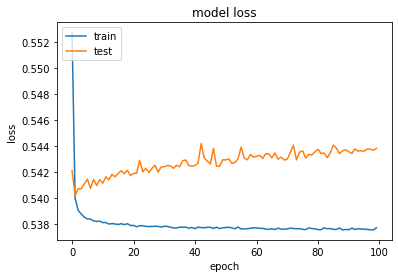

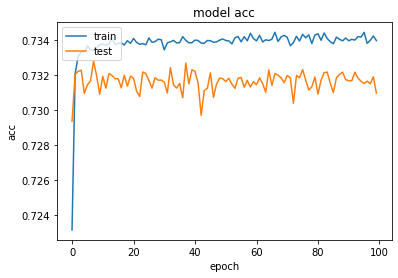

In [ ]:
history = history_stem_glove
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [ ]:
evaluate = model_stem_glove.evaluate(xval_stem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f '%(evaluate[0], evaluate[1]))

Loss score 0.54 : 
Accuracy score: 0.73 


<a href="##sommaire" rev="footnote">&#8617;</a>

### Amélioration du modèle

In [ ]:
len_vocab = 138808
output_dim = 200
max_len = 200
len_padding = 5

tensorflow.random.set_seed(seed)

model_stem_glove_optimised = Sequential()

model_stem_glove_optimised.add(Embedding(input_dim = len_vocab ,
                             output_dim = output_dim,
                             embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                             input_length = max_len + len_padding,
                             trainable = False))
model_stem_glove_optimised.add(GlobalAveragePooling1D())
model_stem_glove_optimised.add(Flatten())
model_stem_glove_optimised.add(Dense(40, activation='relu'))
model_stem_glove_optimised.add(Dropout(rate=0.2))
model_stem_glove_optimised.add(Dense(1, activation="sigmoid"))
model_stem_glove_optimised.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['acc'])

In [ ]:
model_stem_glove_optimised.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 205, 200)          27761600  
                                                                 
 global_average_pooling1d_3   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_7 (Flatten)         (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 40)                8040      
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 41        
                                                      

In [ ]:
t0 = time()
history_stem_glove_optimised = model_stem_glove_optimised.fit(xtrain_stem, 
                             ytrain,
                             validation_data = (xval_stem, yval),
                             epochs = epochs,
                             batch_size = batch_size,
                             verbose = 1)

t_stem_glove_optimised = time() - t0

Epoch 1/100
1252/1252 [==============================] - 8s 6ms/step - loss: 0.5861 - acc: 0.7031 - val_loss: 0.5459 - val_acc: 0.7277
Epoch 2/100
1252/1252 [==============================] - 7s 6ms/step - loss: 0.5400 - acc: 0.7289 - val_loss: 0.5316 - val_acc: 0.7327
Epoch 3/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5324 - acc: 0.7320 - val_loss: 0.5274 - val_acc: 0.7344
Epoch 4/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5292 - acc: 0.7334 - val_loss: 0.5247 - val_acc: 0.7361
Epoch 5/100
1252/1252 [==============================] - 7s 6ms/step - loss: 0.5269 - acc: 0.7348 - val_loss: 0.5232 - val_acc: 0.7372
Epoch 6/100
1252/1252 [==============================] - 7s 6ms/step - loss: 0.5252 - acc: 0.7359 - val_loss: 0.5209 - val_acc: 0.7388
Epoch 7/100
1252/1252 [==============================] - 6s 5ms/step - loss: 0.5236 - acc: 0.7373 - val_loss: 0.5194 - val_acc: 0.7394
Epoch 8/100
1252/1252 [==============================] 

#### Learning Curve

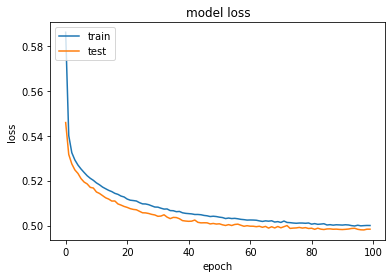

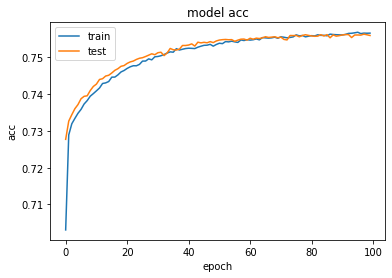

In [ ]:
history = history_stem_glove_optimised
plot_history(history, list(history.history.keys()))

#### Evaluation du modèle

In [ ]:
evaluate = model_stem_glove_optimised.evaluate(xval_stem, yval, verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.50 : 
Accuracy score: 0.76


#### Sauvegarde du modèle

In [ ]:
# saving model

model_stem_glove_optimised.save(path + 'models/model_stem_glove')

print('Model Saved!')

Model Saved!


In [ ]:
import pickle

learning_times = {}
learning_times['lemm_word2vec'] = t_lemm_w2v_optimised
learning_times['lemm_glove'] = t_lemm_glove_optimised
learning_times['stem_word2vec'] = t_stem_w2v_optimised
learning_times['stem_glove'] = t_stem_glove_optimised

# sauvegarde temsp d'entraînement
with open(path + "models/embedding_learning_times.pkl", "wb") as tf:
    pickle.dump(learning_times,tf)
print('Done!')

Done!


In [ ]:
print(learning_times)

{'lemm_word2vec': 682.468090057373, 'lemm_glove': 681.315753698349, 'stem_word2vec': 682.4985361099243, 'stem_glove': 682.5130333900452}


<a href="##sommaire" rev="footnote">&#8617;</a>